In [3]:
#url: /home/delameta-dl/Documents/chest_xray

import time 
import copy 
import glob
import random 

import numpy as np 
import pandas as pd 
from PIL import Image 

from tqdm.auto import tqdm 
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split 

import torch 
import torch.nn as nn 
from torch.optim import Adam 
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms 
from torchvision.models import resnet18, resnet34 


In [4]:
train_normal = glob.glob('/home/delameta-dl/Documents/chest_xray/train/NORMAL/*')
train_pneumonia = glob.glob('/home/delameta-dl/Documents/chest_xray/train/PNEUMONIA/*')

test_normal = glob.glob("/home/delameta-dl/Documents/chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("/home/delameta-dl/Documents/chest_xray/test/PNEUMONIA/*")

In [7]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [15]:
train_labels = [0]*len(train_normal) + [1]*len(train_pneumonia)
test_labels = [0]*len(test_normal) + [1]*len(test_pneumonia)

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

5216 5216
624 624


In [16]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels,stratify=train_labels)



In [17]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)

    fig = plt.figure(figsize=(10,10))
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")
    
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")

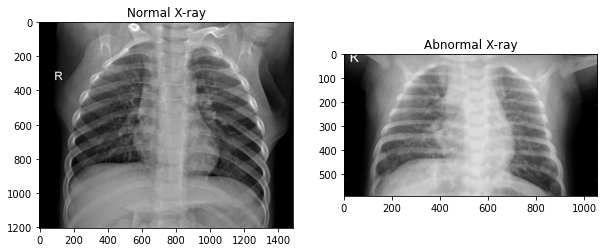

In [18]:
show_random_images()

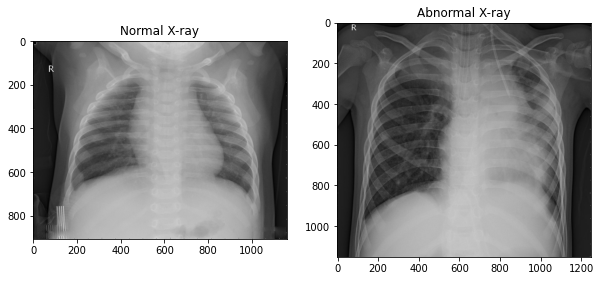

In [19]:
show_random_images()

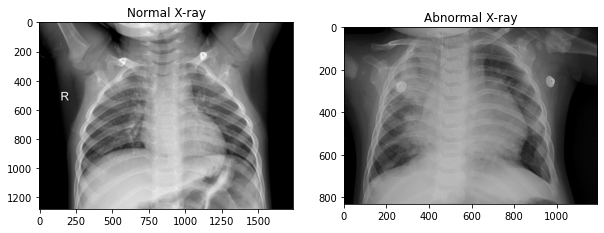

In [20]:
show_random_images()

In [ ]:
class XrayDataset(Dataset):
    def __init__(self, parts, labels , transforms = None):
        self.paths = paths 
        self.labels = labels 
        self.transform = transform 

    def __len__(self):
        return len(self.paths)

    def __getitem__ (self.index):
        path = self.paths[index]
        image = Image.open(path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        label = torch.tensor([label])

        return image, label